In [1]:
from skimage.io import imread
import numpy as np
from scipy.fftpack import dct, idct
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
import time


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Image Processing/lez6_Adaptive_Basis_PCA')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Image Processing/lez6_Adaptive_Basis_PCA'

Useful function for plot the 2D DCT dictionary

In [4]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Load the image and rescale it in $[0,1]$

In [5]:
#img = imread(f'./data/cameraman.png') / 255
#img = imread(f'./data/barbara.png') / 255
img = imread(f'./data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [6]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [7]:
MSE = ((img - noisy_img)**2).mean()
psnr_noisy = 10 * np.log10(1/MSE)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.12')

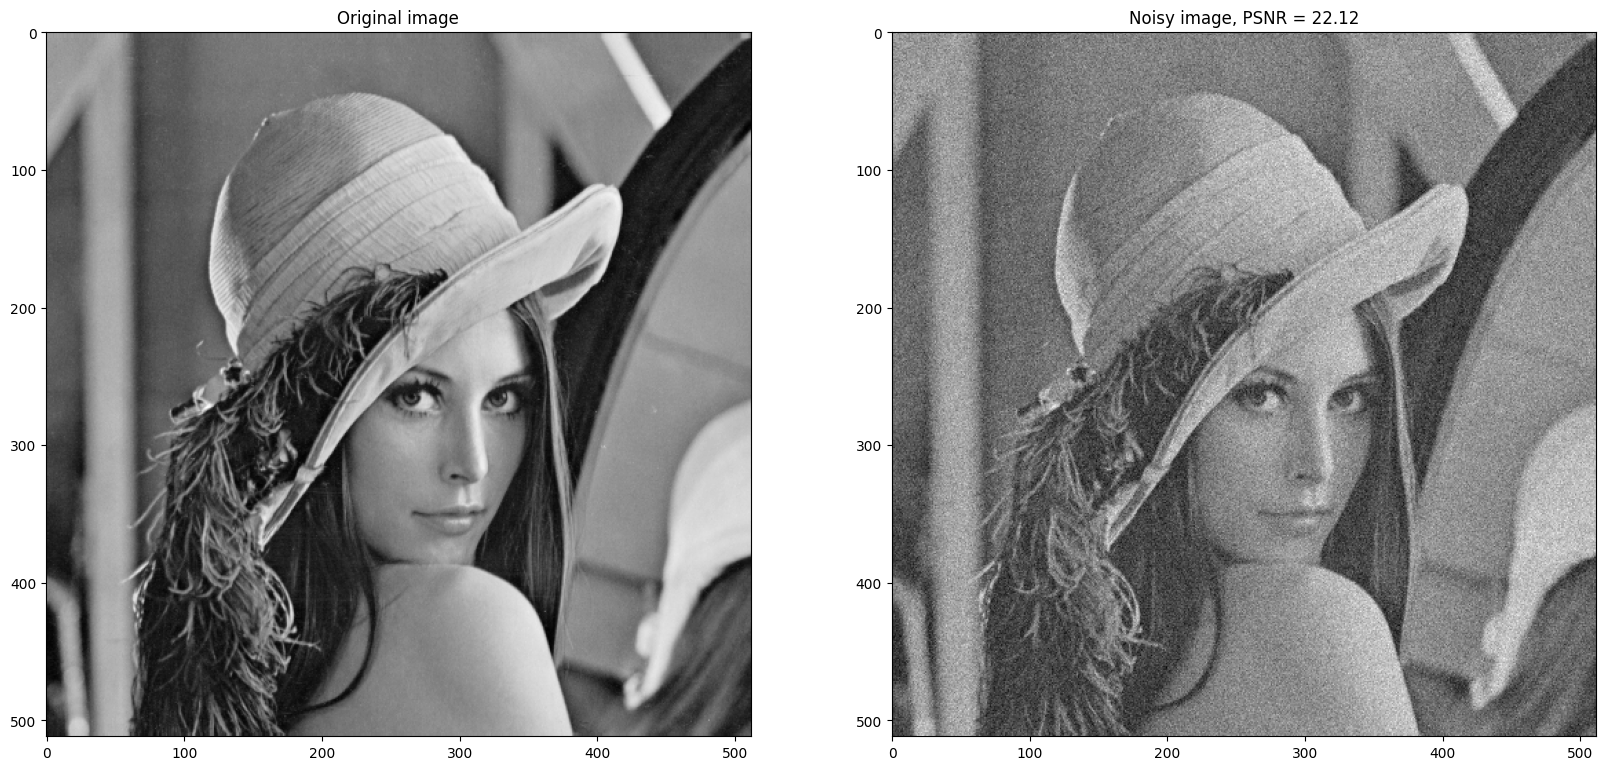

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Generate the Global PCA basis for this image
--------------------------------------------

Set the parameters for denoising

In [9]:
# thresholds on perc. explained variances
PERC_EX_VAR_THRESHOLD = 0.8

# set the threshold for the Hard Thresholding
tau = 3 * sigma_noise # Donoho says: sigma * sqrt(2*log(p^2))

DO_HT = False

Stack all the image patches in a large matrix $P$. Each patch goes in a column of $P$

In [10]:
w = (imsz[0] - p + 1) * (imsz[1] - p + 1)
P = np.zeros((M, w)) 

index_patch = 0
for i in range(0, imsz[0] - p + 1, 1):
    for j in range(0, imsz[1] - p + 1, 1):
#        # extract the patch
        P[:, index_patch] = noisy_img[i:i+p,j:j+p].flatten()
        index_patch += 1

Zero center $P$


In [11]:
avg_patch = np.mean(P, axis=1)
Pc = np.zeros((M, w)) 
for i in range(w):
  Pc[:,i] = P[:,i] -  avg_patch

Compute the PCA transformation via SVD


In [12]:
U, Sigma, V = np.linalg.svd(np.dot(Pc,np.transpose(Pc)), full_matrices=False)

Show the learned PCA basis

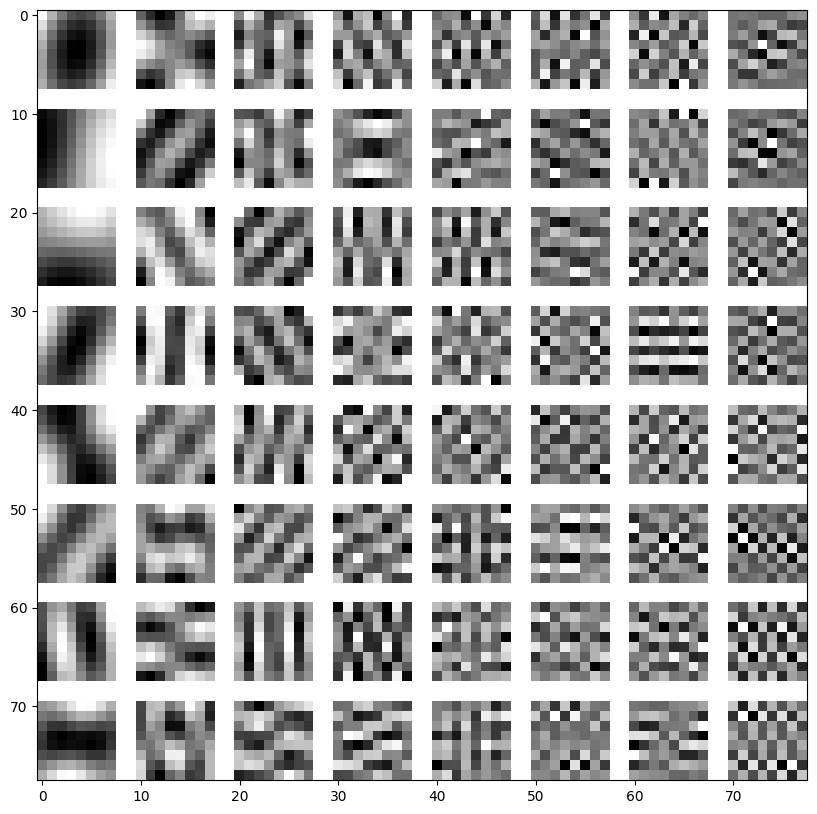

In [13]:
U_img = get_dictionary_img(U)
plt.figure(figsize=(10,10))
plt.imshow(U_img, cmap='gray')

Select only the first components that explained enough variance

In [14]:
cumulative_percentage = np.zeros(M)
var_L = np.zeros(M)
var_M = np.sum(Sigma)
for i in range(M):
  var_L[i] = np.sum(Sigma[0:i+1])
  cumulative_percentage[i] = var_L[i] / var_M

Text(0.5, 1.0, 'Explained variances of 2D PCA- learned')

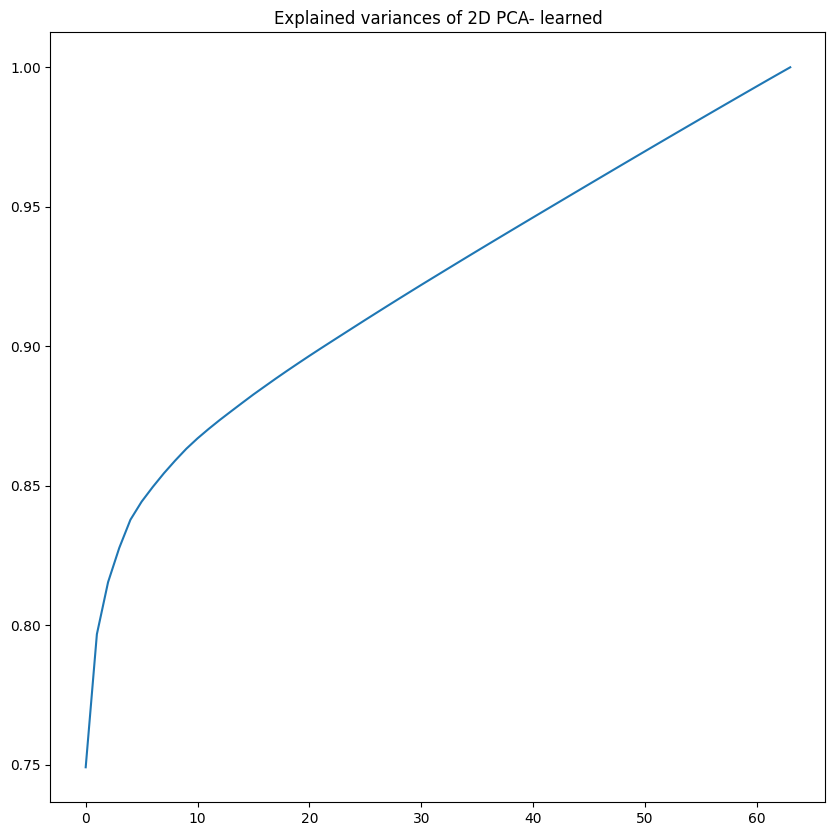

In [15]:
k = np.argmax(cumulative_percentage >= PERC_EX_VAR_THRESHOLD) + 1

plt.figure(figsize=(10,10))
plt.plot(cumulative_percentage)
plt.title('Explained variances of 2D PCA- learned')


Define the PCA projection

In [16]:
Uk = U[:,:k]

Patch-based denoising
---------------------
Initialize the variables

In [17]:
STEP = 1

# initialize the estimated image
img_hat = np.zeros_like(img)

# set the threshold for the Hard Thresholding
tau = 3 * sigma_noise # Donoho says: sigma * sqrt(2*log(p^2))

# initialize the weight matrix
weights = np.zeros_like(img)

DO_HT = False

In [18]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p,j:j+p].flatten() 

        # Preprocessing: remember to subtract the avg_patch (preprocessing used for PCA)
        s = s - avg_patch

        if DO_HT:
            # compute the representation w.r.t. the PCA basis
            x_hat = np.dot(np.transpose(U), s)
            # perform the hard thresholding
            x_HT = x_hat.copy()
            x_HT[np.abs(x_HT) <= tau] = 0
            x_HT[0] = x_hat[0]
            # synthesis: perform the reconstruction
            s_hat = np.dot(U, x_HT)
        else:
            # compute the projection on the basis defined by Uk
            x_hat = np.dot(np.transpose(Uk), s)
            # invert the projection
            s_hat = np.dot(Uk, x_hat)

        # add the avg patch back
        s_hat = s_hat + avg_patch

        # compute the weight for the reconstructed patch
        w = 1

        # put the compressed patch into the compressed image using the computed weight
        img_hat[i:i+p, j:j+p] += s_hat.reshape((p,p)) * w

        # store the weight of the current patch in the weight matrix
        weights[i:i+p, j:j+p] += np.full((p, p), w)

# normalize the estimated image with the computed weights
img_hat = img_hat / weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 28.40')

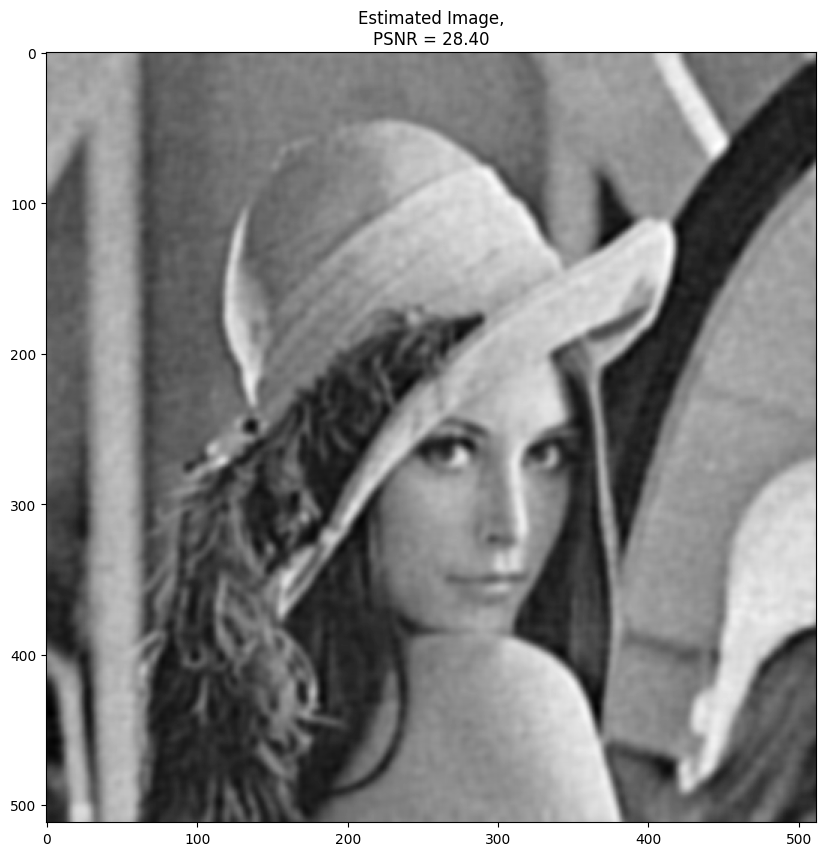

In [19]:
MSE = ((img - img_hat)**2).mean()
psnr_hat = 10 * np.log10(1/MSE)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
